## import needed packages

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
import scipy.stats as ss
import numpy.random as npr
from pprint import pprint
import pandas as pd
from collections import defaultdict as ddict

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

## Real Data 

### the data 

In [3]:
MEM10 = edict()
MEM10.men = edict()
MEM10.pbo= edict()

MEM10.men.n = 107
MEM10.men.mean = 0.77
MEM10.men.sd = 12.06

MEM10.pbo.n = 118
MEM10.pbo.mean = 2.83
MEM10.pbo.sd = 15.70

In [4]:
MEM12 = edict()
MEM12.men = edict()
MEM12.pbo= edict()

MEM12.men.n = 136
MEM12.men.mean = 0.97
MEM12.men.sd = 11.26

MEM12.pbo.n = 125
MEM12.pbo.mean = 0.86
MEM12.pbo.sd = 11.08

In [5]:
MEM02 = edict()
MEM02.men = edict()
MEM02.pbo= edict()

MEM02.men.n = 171
MEM02.men.mean = -0.75
MEM02.men.sd = 11.03

MEM02.pbo.n = 152
MEM02.pbo.mean = 2.78
MEM02.pbo.sd = 13.48

In [6]:
MEM01 = edict()
MEM01.men = edict()
MEM01.pbo= edict()

MEM01.men.n = 133
MEM01.men.mean = -2.11
MEM01.men.sd = 15.12

MEM01.pbo.n = 127
MEM01.pbo.mean = 0.51
MEM01.pbo.sd = 13.75

In [7]:
LU = edict()
LU.men = edict()
LU.pbo= edict()

LU.men.n = 146
LU.men.mean = -0.36
LU.men.sd = 10.40

LU.pbo.n = 64
LU.pbo.mean = -2.23
LU.pbo.sd = 9.55

In [8]:
MRZ = edict()
MRZ.men = edict()
MRZ.pbo= edict()

MRZ.men.n = 97
MRZ.men.mean = 0.09
MRZ.men.sd = 15.92

MRZ.pbo.n = 84
MRZ.pbo.mean = 2.89
MRZ.pbo.sd = 16.13

## New Model

The model is $Y_i \sim N(\theta+\beta X_i, \sigma^2)$.

Our target is to estimate the $\beta$. 

In [9]:
def DataPre(D):
    D.n = D.men.n + D.pbo.n
    n, n1, n2 = D.n, D.men.n, D.pbo.n
    D.men.mle = D.men.mean
    D.pbo.mle = D.pbo.mean
    mle1, mle2 = D.men.mle, D.pbo.mle
    D.betamle = (n*n1*mle1 - n1*(n1*mle1 + n2*mle2))/(n*n1-n1**2)
    D.thetamle = mle2
    D.sigma2mle = (n1*D.men.sd**2+ n1*(mle1-D.betamle-D.thetamle)**2 + n2*D.pbo.sd**2)/n
    D.betaUI = n1/D.sigma2mle/n
    D.thetaUI = 1/D.sigma2mle
    return D

In [10]:
MEM01 = DataPre(MEM01)
MEM02 = DataPre(MEM02)
MEM10 = DataPre(MEM10)
MEM12 = DataPre(MEM12)
LU = DataPre(LU)
MRZ = DataPre(MRZ)

### Raw Model

In [11]:
def GetNewRawModel(D):
    n = D.n
    n1 = D.men.n
    n2 = D.pbo.n
    model = pm.Model()
    def loglike(mlem1, mlem2, mlev1, mlev2):
        return -n/2 * np.log(sigma2) - (n1*mlev1+ n1*(mlem1-theta-beta)**2 + n2*mlev2+ n2*(mlem2-theta)**2)/2/sigma2
    
    with model:
        theta = pm.Normal("theta", mu=0, sigma=10)
        beta = pm.Normal("beta", mu=0, sigma=10)
        sigma2 = pm.InverseGamma("sigma2", alpha=0.01, beta=0.01)
        pm.DensityDist("Distdensity", loglike, observed={"mlem1":[D.men.mle], "mlev1":[D.men.sd**2], 
                                                         "mlem2":[D.pbo.mle], "mlev2":[D.pbo.sd**2]})
    return model
        

In [12]:
LUmodel = GetNewRawModel(LU)
with LUmodel:
    step = pm.Metropolis()
    trace_LU = pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma2]
>Metropolis: [beta]
>Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:30<00:00, 1945.89draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [13]:
MRZmodel = GetNewRawModel(MRZ)
with MRZmodel:
    step = pm.Metropolis()
    trace_MRZ = pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma2]
>Metropolis: [beta]
>Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:24<00:00, 2483.84draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [14]:
MEM01model = GetNewRawModel(MEM01)
with MEM01model:
    step = pm.Metropolis()
    trace_MEM01 = pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma2]
>Metropolis: [beta]
>Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:29<00:00, 2018.38draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [15]:
MEM02model = GetNewRawModel(MEM02)
with MEM02model:
    step = pm.Metropolis()
    trace_MEM02 = pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma2]
>Metropolis: [beta]
>Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:31<00:00, 1898.76draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [16]:
MEM10model = GetNewRawModel(MEM10)
with MEM10model:
    step = pm.Metropolis()
    trace_MEM10 = pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma2]
>Metropolis: [beta]
>Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:33<00:00, 1788.31draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [17]:
MEM12model = GetNewRawModel(MEM12)
with MEM12model:
    step = pm.Metropolis()
    trace_MEM12= pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma2]
>Metropolis: [beta]
>Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:33<00:00, 1803.54draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [19]:
betas = [trace_LU["beta"], trace_MRZ["beta"], trace_MEM01["beta"], trace_MEM02["beta"], trace_MEM10["beta"], trace_MEM12["beta"]]
thetas = [trace_LU["theta"], trace_MRZ["theta"], trace_MEM01["theta"], trace_MEM02["theta"], trace_MEM10["theta"], trace_MEM12["theta"]]
sigma2s = [trace_LU["sigma2"], trace_MRZ["sigma2"], trace_MEM01["sigma2"], trace_MEM02["sigma2"], trace_MEM10["sigma2"], trace_MEM12["sigma2"]]

In [20]:
NewRawRes = ddict(list)
NewRawRes["data"] = ["LU", "MRZ", "MEM01", "MEM02", "MEM10", "MEM12"]
for i in range(6):
    NewRawRes["bmean"].append(betas[i].mean())
    NewRawRes["blow"].append(np.quantile(betas[i], 0.025))
    NewRawRes["bup"].append(np.quantile(betas[i], 0.975))
    NewRawRes["tmean"].append(thetas[i].mean())
    NewRawRes["tlow"].append(np.quantile(thetas[i], 0.025))
    NewRawRes["tup"].append(np.quantile(thetas[i], 0.975))
    NewRawRes["smean"].append(sigma2s[i].mean())
    NewRawRes["slow"].append(np.quantile(sigma2s[i], 0.025))
    NewRawRes["sup"].append(np.quantile(sigma2s[i], 0.975))

In [21]:
ResDf = pd.DataFrame(NewRawRes)

In [22]:
ResDf

,data,bmean,blow,bup,tmean,tlow,tup,smean,slow,sup
0,LU,1.818895,-1.185250,4.743892,-2.172828,-4.594795,0.348898,104.834680,86.049290,127.210767
1,MRZ,-2.540604,-7.057967,1.967554,2.703622,-0.540690,6.045266,262.419710,213.077055,322.748908
2,MEM01,-2.567890,-5.993882,0.950193,0.479045,-2.011653,2.973771,212.472659,179.530104,252.091965
3,MEM02,-3.412352,-6.094288,-0.745392,2.700630,0.810943,4.650048,151.677841,129.764436,177.383800
4,MEM10,-2.016964,-5.594576,1.724798,2.795620,0.233216,5.318046,202.304153,167.765055,243.173471
5,MEM12,0.092918,-2.553391,2.800851,0.865128,-1.064972,2.838220,127.032461,107.044652,150.682021


### UIPD model

In [12]:
def getNewUIPDcon(D, Ds):
    nD = len(Ds)
    n = D.n
    n1 = D.men.n
    n2 = D.pbo.n
    
    nsSum = np.sum([Dh.n for Dh in Ds])
    betaMeans = [Dh.betamle for Dh in Ds]
    betaUIs = [Dh.betaUI for Dh in Ds]
    thetaMeans = [Dh.thetamle for Dh in Ds]
    thetaUIs = [Dh.thetaUI for Dh in Ds]
    UIPDm = pm.Model()
    def loglike(mlem1, mlem2, mlev1, mlev2):
        return -n/2 * np.log(sigma2) - (n1*mlev1+ n1*(mlem1-thetah-betah)**2 \
                                        + n2*mlev2+ n2*(mlem2-thetah)**2)/2/sigma2
    with UIPDm:
        pis = pm.Dirichlet("pis", np.ones(nD))
        sigma2 = pm.InverseGamma("sigma2", alpha=0.01, beta=0.01)
        M = pm.Uniform("M", lower=0, upper=nsSum)

        #thetan = 0
        betan = 0
        #sigma2n_inv = 0
        sigma2betan_inv = 0
        for i in range(nD):
            #thetan += pis[i] * thetaMeans[i]
            betan += pis[i] * betaMeans[i]
            #sigma2n_inv += pis[i] * thetaUIs[i]
            sigma2betan_inv += pis[i] * betaUIs[i]
        #sigma2n = 1/M/sigma2n_inv
        sigma2betan = 1/M/sigma2betan_inv
        thetah = pm.Normal("thetah", mu=0, sigma=10)
        betah = pm.Normal("betah", mu=betan, sigma=np.sqrt(sigma2betan))
        pm.DensityDist("Distdensity", loglike, observed={"mlem1":[D.men.mle], "mlev1":[D.men.sd**2], 
                                                         "mlem2":[D.pbo.mle], "mlev2":[D.pbo.sd**2]})
    return UIPDm

In [25]:
NewModel = getNewUIPDcon(MRZ, [MEM01, MEM02, MEM10, MEM12])
with NewModel:
    step = pm.Metropolis()
    #trace_new_UIPD = pm.sample(10000, tune=5000)
    trace_new_UIPD = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [betah]
>Metropolis: [thetah]
>Metropolis: [M]
>Metropolis: [sigma2]
>Metropolis: [pis]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:33<00:00, 1803.77draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [26]:
np.quantile(trace_new_UIPD["thetah"], [0.025, 0.975])

array([-0.06152814,  5.05183421])

In [27]:
np.quantile(trace_new_UIPD["betah"], [0.025, 0.975])

array([-4.16406595, -0.12488887])

In [28]:
np.quantile(trace_new_UIPD["M"], [0.025, 0.975])

array([  50.63751637, 1044.808194  ])

In [29]:
np.quantile(trace_new_UIPD["pis"], [0.025, 0.975], axis=0)

array([[0.00836647, 0.0093854 , 0.00954301, 0.00693886],
       [0.70653258, 0.71450779, 0.70965164, 0.67641726]])

In [30]:
pm.summary(trace_new_UIPD)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
thetah,2.494,1.298,0.000,4.900,0.018,0.012,5427.0,5427.0,5425.0,8060.0,1.0
betah,-2.145,1.015,-3.993,-0.162,0.017,0.012,3486.0,3486.0,3464.0,5414.0,1.0
pis[0],0.252,0.195,0.000,0.611,0.003,0.002,3679.0,3679.0,3222.0,3606.0,1.0
pis[1],0.258,0.195,0.000,0.613,0.004,0.002,3069.0,3069.0,2848.0,3994.0,1.0
pis[2],0.257,0.195,0.000,0.619,0.003,0.002,3253.0,3253.0,3014.0,3853.0,1.0
pis[3],0.233,0.184,0.000,0.571,0.004,0.003,2328.0,2328.0,2215.0,3983.0,1.0
sigma2,261.109,28.015,209.358,313.875,0.322,0.227,7591.0,7591.0,7428.0,7545.0,1.0
M,568.732,298.870,93.311,1064.471,3.650,2.581,6705.0,6705.0,6491.0,7391.0,1.0


### full data

In [31]:
NewModelfull = getNewUIPDcon(MRZ, [LU, MEM01, MEM02, MEM10, MEM12])
with NewModelfull:
    #step = pm.Metropolis()
    trace_new_UIPDfull = pm.sample(10000, tune=10000)
    #trace_new_UIPD = pm.sample(10000, tune=5000,step=step)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betah, thetah, M, sigma2, pis]
Sampling 4 chains, 0 divergences: 100%|██████████| 80000/80000 [01:35<00:00, 839.39draws/s] 


In [32]:
np.quantile(trace_new_UIPDfull["thetah"], [0.025, 0.975])

array([-0.41166303,  4.79340807])

In [33]:
np.quantile(trace_new_UIPDfull["betah"], [0.025, 0.975])

array([-3.64038854,  0.53010062])

In [34]:
np.quantile(trace_new_UIPDfull["M"], [0.025, 0.975])

array([  51.62007501, 1245.94130023])

In [35]:
np.quantile(trace_new_UIPDfull["pis"], [0.025, 0.975], axis=0)

array([[0.00559191, 0.00712399, 0.00667419, 0.00649924, 0.00608055],
       [0.54809902, 0.61871867, 0.62275043, 0.60753618, 0.57829058]])

In [36]:
pm.summary(trace_new_UIPDfull)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
thetah,2.173,1.328,-0.353,4.633,0.008,0.006,30462.0,28198.0,30495.0,27913.0,1.0
betah,-1.527,1.064,-3.461,0.514,0.007,0.005,22487.0,20183.0,23063.0,25307.0,1.0
pis[0],0.177,0.147,0.000,0.451,0.001,0.001,25746.0,24740.0,22357.0,18257.0,1.0
pis[1],0.210,0.168,0.000,0.522,0.001,0.001,41251.0,37649.0,33245.0,18809.0,1.0
pis[2],0.216,0.170,0.000,0.529,0.001,0.001,36513.0,32955.0,33005.0,20876.0,1.0
pis[3],0.206,0.165,0.000,0.513,0.001,0.001,36586.0,32816.0,34114.0,24080.0,1.0
pis[4],0.191,0.157,0.000,0.485,0.001,0.001,35948.0,32102.0,35318.0,26137.0,1.0
sigma2,261.481,27.822,212.178,315.394,0.130,0.094,45586.0,43882.0,46917.0,29152.0,1.0
M,657.575,360.146,87.813,1263.807,1.898,1.400,36017.0,33099.0,32304.0,21705.0,1.0


In [37]:
pis = trace_new_UIPDfull["pis"]

In [38]:
pislong = list(pis[:, 1]) + list(pis[:, 2]) + list(pis[:, 0]) + list(pis[:, 3]) + list(pis[:, 4])

In [39]:
typelong = ["MEM-MD-01"] * 40000 + ["MEM-MD-02"] * 40000 + ["LU-99679"] * 40000 + ["MEM-MD-10"] * 40000 + ["MEM-MD-12"] * 40000

In [40]:
pisdf = pd.DataFrame({"pis":pislong, "type": typelong})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f414a623860>,
      dtype=object)

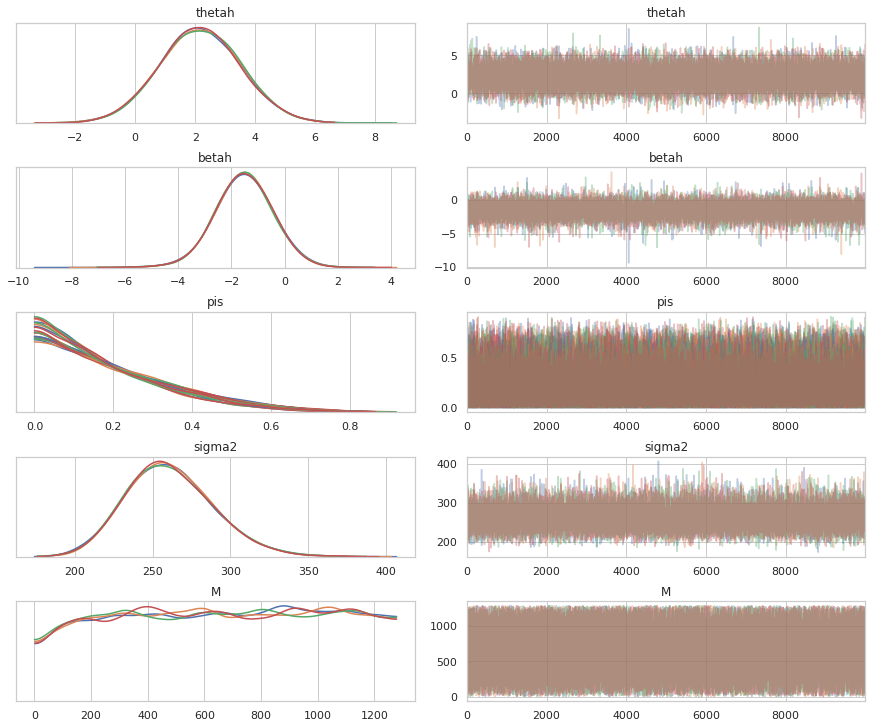

In [59]:
pm.traceplot(trace_new_UIPDfull)